The notebook is split into two parts:
1. Part 1: Train a query and item towers
2. Part 2: Generate Index table and run validation

In [1]:
from datasets import load_from_disk
import os

filepath = '../../datasets/yambda/processed'
train_processed = load_from_disk(os.path.join(filepath, "train"))
print("Dataset loaded successfully:")
print(train_processed)

/Users/paataugrekhelidze/Projects/Recsys/retrieval/two-tower/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset loaded successfully:
Dataset({
    features: ['timestamp', 'item_id', 'is_organic', 'played_ratio_pct', 'track_length_seconds', 'uid', 'artist_id', 'album_id'],
    num_rows: 9228
})


### Part 1: Build Query and Item towers

In [2]:
import torch

len_unique_users = 9238
len_unique_items = 877168
len_unique_albums = 3367691
len_unique_artists = 1293394

user_embed_size = 14
item_embed_size = 20
album_embed_size = 22
artist_embed_size = 21
item_embed = torch.nn.Embedding(num_embeddings=len_unique_items+1, embedding_dim=item_embed_size)
album_embed = torch.nn.Embedding(num_embeddings=len_unique_albums+1, embedding_dim=album_embed_size)
artist_embed = torch.nn.Embedding(num_embeddings=len_unique_artists+1, embedding_dim=artist_embed_size)

with torch.no_grad():
    # alternatively use hashes to assign "unique" embeddings to unseen items, albums,...
    # give the size of the hash array, there will be some collisions. For simplicity let's just have a single embedding for now...
    print(f"shared learnable embedding for unknown items: {item_embed(torch.tensor([877168]))}")

shared learnable embedding for unknown items: tensor([[ 0.0427, -2.1584, -2.2904, -0.7428,  0.9641, -0.9047,  0.9337, -1.2992,
          0.6006,  0.0974, -1.1870, -0.0789, -0.4244, -0.2398, -1.8931,  1.2902,
          0.4198,  0.9623,  0.3910, -0.3527]])


In [3]:
from tower import QueryTower

query_input_size = user_embed_size + 2*item_embed_size + 2*artist_embed_size + 2*album_embed_size + 3

# initialize and test query tower
query_model = QueryTower(input_size = query_input_size,
                         hidden_size = [1024, 512, 128], # Youtube paper 2019[2] section 6.3
                         user_num_embeddings = len_unique_users+1,
                         user_embed_size = user_embed_size,
                         item_embed = item_embed,
                         artist_embed = artist_embed,
                         album_embed = album_embed,
                         log_age_mean = 15.874020,
                         log_age_std = 1.090574
                        )

In [4]:
from tower import ItemTower

# initialize and test item tower
candidate_input_size = item_embed_size + artist_embed_size + album_embed_size + 1

item_model = ItemTower(input_size = candidate_input_size,
                       hidden_size = [1024, 512, 128],
                       item_embed = item_embed,
                       artist_embed = artist_embed,
                       album_embed = album_embed
                       )

In [5]:
from torch.utils.data import DataLoader
import tower


# loop through batches and implement in_batch softmax

EPOCHS = 30
BATCH = 2048
# BATCH = 32
WORKERS = 8
TAU = 0.01 # <1 sharpens predictions for logits that already had high values and helps separate pos from neg samples

# dynamically estimate frequency of candidate ids in batch using weighted moving average (frequency: # of steps between seeing interaction with the same candidate ID)
# Youtube paper 2019[2] section 4
H = len_unique_users # large size to prevent collisions
alpha = 0.05

# reinitialize with multiple workers and bigger batch
all_params = (
    list(query_model.user_embed.parameters()) +
    list(query_model.hidden_layers.parameters()) +
    list(item_model.hidden_layers.parameters()) +
    list(item_embed.parameters()) +
    list(artist_embed.parameters()) +
    list(album_embed.parameters())
)
optimizer = torch.optim.AdamW(
    all_params, 
    lr=0.001
)
device = "mps"

train_dataset = tower.MusicWindowDataset(data = train_processed, 
                                   n = 10, 
                                   global_t_max = 25395200,
                                   max_windows_per_user=500)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=WORKERS, persistent_workers=True)

tower_solver = tower.TowerSolver(
                    query_model=query_model,
                    item_model=item_model,
                    device = device,
                    optimizer=optimizer,
                    epochs = EPOCHS,
                    batch_size = BATCH,
                    data = train_dataloader,
                    reset = True,
                    H = H,
                    alpha = alpha,
                    tau=TAU
                )
tower_solver.train()

Generating samples from sequences...
Generated 4135761 total samples.
[0/30] Loss: 3.604418 time: 67.32998498678208m
Checkpoint saved at ./checkpoints/checkpoint_epoch_0.pth
Checkpoint saved at ./checkpoints/last_checkpoint.pth
[1/30] Loss: 2.949955 time: 67.12427116235098m
Checkpoint saved at ./checkpoints/checkpoint_epoch_1.pth
Checkpoint saved at ./checkpoints/last_checkpoint.pth
[2/30] Loss: 2.711084 time: 66.39599741299948m
Checkpoint saved at ./checkpoints/checkpoint_epoch_2.pth
Checkpoint saved at ./checkpoints/last_checkpoint.pth
[3/30] Loss: 2.560514 time: 67.00215453306834m
Checkpoint saved at ./checkpoints/checkpoint_epoch_3.pth
Checkpoint saved at ./checkpoints/last_checkpoint.pth
[4/30] Loss: 2.454837 time: 66.6570083340009m
Checkpoint saved at ./checkpoints/checkpoint_epoch_4.pth
Checkpoint saved at ./checkpoints/last_checkpoint.pth
[5/30] Loss: 2.375314 time: 67.16976869901022m
Checkpoint saved at ./checkpoints/checkpoint_epoch_5.pth
Checkpoint saved at ./checkpoints/las

KeyboardInterrupt: 

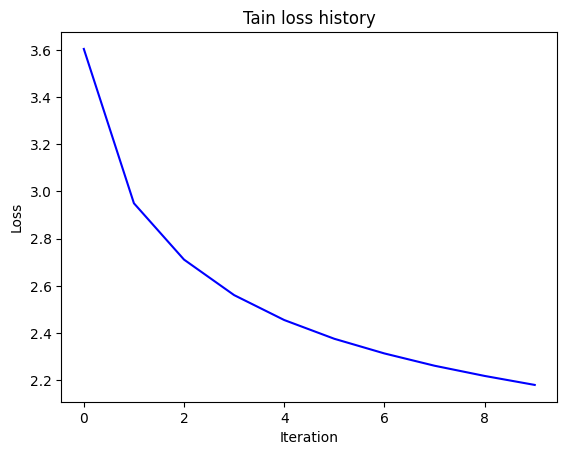

In [ ]:
import matplotlib.pyplot as plt
import re
epochs_ix = []
checkpoints = "./checkpoints"
for f in os.listdir(checkpoints):
    matches = re.findall(r'-?\d+', f)
    if len(matches):
        epochs_ix.append(int(matches[0]))

loss_history = []
for ix in sorted(epochs_ix):
    checkpoint = torch.load(os.path.join(checkpoints, f"checkpoint_epoch_{ix}.pth"))
    # epoch = checkpoint["epoch"]
    loss_history.append(checkpoint["loss"])


# Plot the training losses.
plt.plot(loss_history, color='blue', label='Train')
# plt.plot(val_loss_history, color='orange', label='Val')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Tain loss history')
plt.show()

### Part 2: Build Index Table

In order to quickly extract item embedding, we need to store them in a data structure that is fast, memory efficient, and accurate. The most accurate, and often used as a baseline, is knn. However, knn is terribly inefficient (O(N x D) runtime and O(N x D x 4) memory). So the techniques listed below will try to approximate knn (ANN) by trading off between speed, memory, and accuracy.

IVF - Kmeans clustering
- build: trains a kmeans algorithm to find nlist amount of centroids that represent centers of the clusters
- inference: given a query embedding, find nprobe amount of centroids closests to the query embedding, then search exhaustively for the closest item embeddings within the candidate clusters.
- Better speed, worse accuracy, slighly worse memory (D x 4 bytes per vector vs D x 4 + 8 bytes per vector)

PQ - Compresses D into M dimension.
- build: splits item vector into M subspaces, trains kmeans for each subspace separately, uses cluster ID of the closest centroid in each subspace to represent the original embedding.
- Inference: given a query, split the embedding into M subspaces, generate a distance matrix d between query embedding subspaces and all centroids in each subspace. Iterate through each compressed item embeddings, find appropriate distance rows,columns that match cluster IDs of item embedding in each subspace. aggregate the partial distances from each subspace. Note: Some distance equations (ex: L2, inner product) are capable of aggragating from partial distances, not all (ex: cosine)
- efficient memory, worst accuracy

HNSW - Builds multilayer graph.
- build: for each item embeddeing, randomly select in how many layers it should be represented in the graph. Insert top to bottom by starting from the entrypoint(s), defined by efConstruction, greedily find the nearest vertices at each layer and use them as entrypoints to the lower layers. Connect the item embedding to M vertices in layers where it is represented.
- inference: given a query, starting from the top entrypoint(s), defined by efsearch, greedily find the nearest vertices at each layer and use them as entrypoints to the lower layers. select top k closest vertices to the query embedding at the bottom-most layer.
- log(N) speed, great accuracy, not memory efficient


In this use case, let's use HNSW+IVF+PQ and combine all the benefits. Build Kmean cluster using IVF, represent the IVF centroid in HNSW because we can search through the centroid in Log(N) inseat of O(N) in regular IVF, this allows us to make nlist bigger. Use PQ to comress actuall item embedding in each IVF cluster to save memory.

In [7]:
from tower import QueryTower, ItemTower
import os


query_input_size = user_embed_size + 2*item_embed_size + 2*artist_embed_size + 2*album_embed_size + 3
candidate_input_size = item_embed_size + artist_embed_size + album_embed_size + 1

# initialize and test query tower
query_model = QueryTower(input_size = query_input_size,
                         hidden_size = [1024, 512, 128],
                         user_num_embeddings = len_unique_users+1,
                         user_embed_size = user_embed_size,
                         item_embed = item_embed,
                         artist_embed = artist_embed,
                         album_embed = album_embed,
                         log_age_mean = 15.874020,
                         log_age_std = 1.090574
                        )


# initialize and test item tower
item_model = ItemTower(input_size = candidate_input_size,
                       hidden_size = [1024, 512, 128],
                       item_embed = item_embed,
                       artist_embed = artist_embed,
                       album_embed = album_embed
                       )

# load last checkpoint
checkpoints = "./checkpoints"
checkpoint = torch.load(os.path.join(checkpoints, f"last_checkpoint.pth"))
query_model.load_state_dict(checkpoint["query_model_state_dict"])
item_model.load_state_dict(checkpoint["item_model_state_dict"])


<All keys matched successfully>

In [8]:
from datasets import load_from_disk
import os

filepath = '../../datasets/yambda/items'
train_item_ds = load_from_disk(os.path.join(filepath, "train"))
val_item_ds = load_from_disk(os.path.join(filepath, "val"))
print("Datasets loaded successfully")

Datasets loaded successfully


In [9]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader


device = "mps"
B = 8192
item_model.to(device)
item_model.eval()

item_dataloader = DataLoader(train_item_ds.with_format("torch"), batch_size=B)
all_train_embeddings = []
all_train_item_ids = []

print("Generating embeddings for the training set...")
with torch.no_grad():
    for batch in tqdm(item_dataloader):
        
        all_train_item_ids.append(batch["candidate_id"].numpy())

        # Move batch to the correct device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Generate embeddings
        embeddings = item_model(batch)        
        # Normalize embeddings (important for Faiss with inner product)
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        # Move to CPU and convert to numpy
        all_train_embeddings.append(embeddings.cpu().numpy())

train_embeddings_np = np.concatenate(all_train_embeddings, axis=0)
train_item_id_np = np.concatenate(all_train_item_ids, axis=0)

Generating embeddings for the training set...


100%|██████████| 106/106 [00:17<00:00,  5.96it/s]


In [10]:
item_dataloader = DataLoader(val_item_ds.with_format("torch"), batch_size=B)
all_val_embeddings = []
all_val_item_ids = []

print("Generating embeddings for the validation set...")
with torch.no_grad():
    for batch in tqdm(item_dataloader):

        all_val_item_ids.append(batch["candidate_id"].numpy())
        # Move batch to the correct device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Generate embeddings
        item_embeddings = item_model(batch)        
        # Normalize embeddings (important for Faiss with inner product)
        item_embeddings = torch.nn.functional.normalize(item_embeddings, p=2, dim=1)
        
        # Move to CPU and convert to numpy
        all_val_embeddings.append(item_embeddings.cpu().numpy())

val_embeddings_np = np.concatenate(all_val_embeddings, axis=0)
val_item_id_np = np.concatenate(all_val_item_ids, axis=0)

Generating embeddings for the validation set...


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


In [11]:
print(train_embeddings_np.shape, train_item_id_np.shape)
print(val_embeddings_np.shape, val_item_id_np.shape)

(862091, 128) (862091,)
(15077, 128) (15077,)


In [51]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import faiss

# define index table metrics
d = 128
M = 32 # number of edges for each vertice in HNSW graph

nlist = 64 # number of Voronoi clusters (IVF)
nsubspaces = 16 # number of subspaces to split each embedding (PQ), ideally divisible by 8
nbits = 8 # 2^8 = 256 clusters, number of bits to encode cluster ID in each subspace
metric = faiss.METRIC_INNER_PRODUCT
# metric = faiss.METRIC_L2

# quantizer = faiss.IndexHNSWFlat(d, M, metric) HNSW is an overkill if nlist is small
# quantizer = faiss.IndexFlatIP(d)
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFPQ(quantizer, d, nlist, nsubspaces, nbits, metric)

# Shuffle and take a subset for training, higher size simply crashes the kernel
sample_size = 400_000
train_sample = train_embeddings_np[np.random.choice(train_embeddings_np.shape[0], sample_size, replace=False)]

index.train(train_sample)


In [52]:

all_embeddings = np.vstack([train_embeddings_np, val_embeddings_np]).astype('float32')
all_ids = np.concatenate([train_item_id_np, val_item_id_np]).astype('int64')

index.add_with_ids(all_embeddings, all_ids)

# save index table
faiss.write_index(index, "items.index")

In [16]:
# knn - inefficient but 100% accurate for nearest neighbor retrieval, used to benchmark ANN
baseline_index = faiss.IndexIDMap(faiss.IndexFlatIP(d))
baseline_index.add_with_ids(all_embeddings, all_ids)
faiss.write_index(baseline_index, "baseline.index")